In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Define the column names you want to assign
column_names = ['Date', 'Hour (24-hour clock)', 'Origin Station', 'Destination Station', 'Number of Exits']

# Load the CSV with the specified column names
data = pd.read_csv('date-hour-soo-dest-2023.csv', header=None, names=column_names)

In [12]:
# Display the first few rows to verify
data.head()

,Date,Hour (24-hour clock),Origin Station,Destination Station,Number of Exits
0,2023-01-01,0,12TH,12TH,1
1,2023-01-01,0,12TH,16TH,1
2,2023-01-01,0,12TH,19TH,2
3,2023-01-01,0,12TH,24TH,3
4,2023-01-01,0,12TH,ASHB,2


In [24]:
data.tail()

,Date,Hour (24-hour clock),Origin Station,Destination Station,Number of Exits
8690362,2023-12-31,23,WOAK,MONT,2
8690363,2023-12-31,23,WOAK,NBRK,2
8690364,2023-12-31,23,WOAK,POWL,6
8690365,2023-12-31,23,WOAK,ROCK,1
8690366,2023-12-31,23,WOAK,WOAK,5


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8690367 entries, 0 to 8690366
Data columns (total 5 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   Date                  object
 1   Hour (24-hour clock)  int64 
 2   Origin Station        object
 3   Destination Station   object
 4   Number of Exits       int64 
dtypes: int64(2), object(3)
memory usage: 331.5+ MB


In [18]:
data.describe()

,Hour (24-hour clock),Number of Exits
count,8.690367e+06,8.690367e+06
mean,1.367256e+01,5.655537e+00
std,5.308803e+00,1.112232e+01
min,0.000000e+00,1.000000e+00
25%,9.000000e+00,1.000000e+00
50%,1.400000e+01,2.000000e+00
75%,1.800000e+01,5.000000e+00
max,2.300000e+01,1.030000e+03


In [22]:
data.isnull().sum()

Date                    0
Hour (24-hour clock)    0
Origin Station          0
Destination Station     0
Number of Exits         0
dtype: int64

In [26]:
# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'])

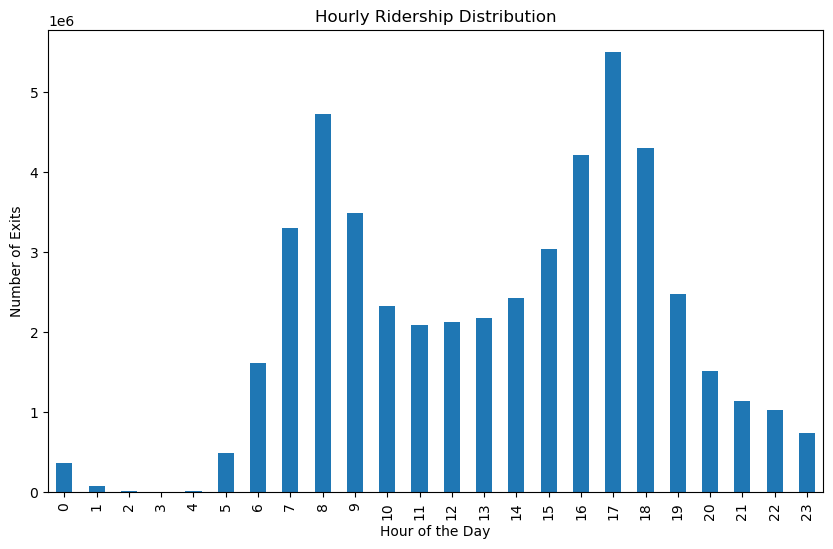

In [32]:
# Plot hourly ridership distribution
plt.figure(figsize=(10, 6))
data.groupby('Hour (24-hour clock)')['Number of Exits'].sum().plot(kind='bar')
plt.title('Hourly Ridership Distribution')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Exits')
plt.show()

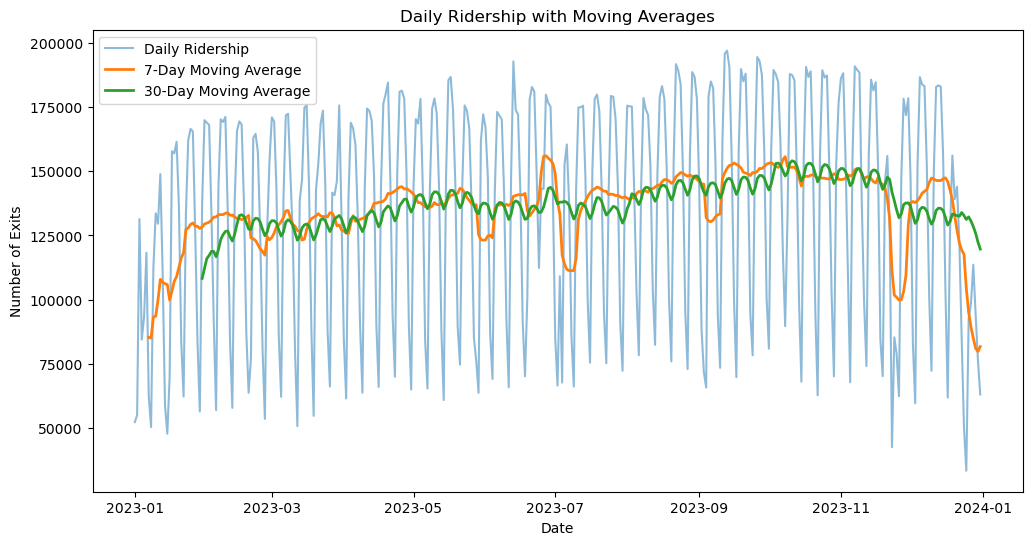

In [34]:
# Aggregate ridership per day
daily_ridership = data.groupby('Date')['Number of Exits'].sum()

# Calculate moving averages (7-day and 30-day)
daily_ridership_7d = daily_ridership.rolling(window=7).mean()
daily_ridership_30d = daily_ridership.rolling(window=30).mean()

# Plot the trends
plt.figure(figsize=(12, 6))
plt.plot(daily_ridership, label='Daily Ridership', alpha=0.5)
plt.plot(daily_ridership_7d, label='7-Day Moving Average', linewidth=2)
plt.plot(daily_ridership_30d, label='30-Day Moving Average', linewidth=2)
plt.title('Daily Ridership with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Number of Exits')
plt.legend()
plt.show()


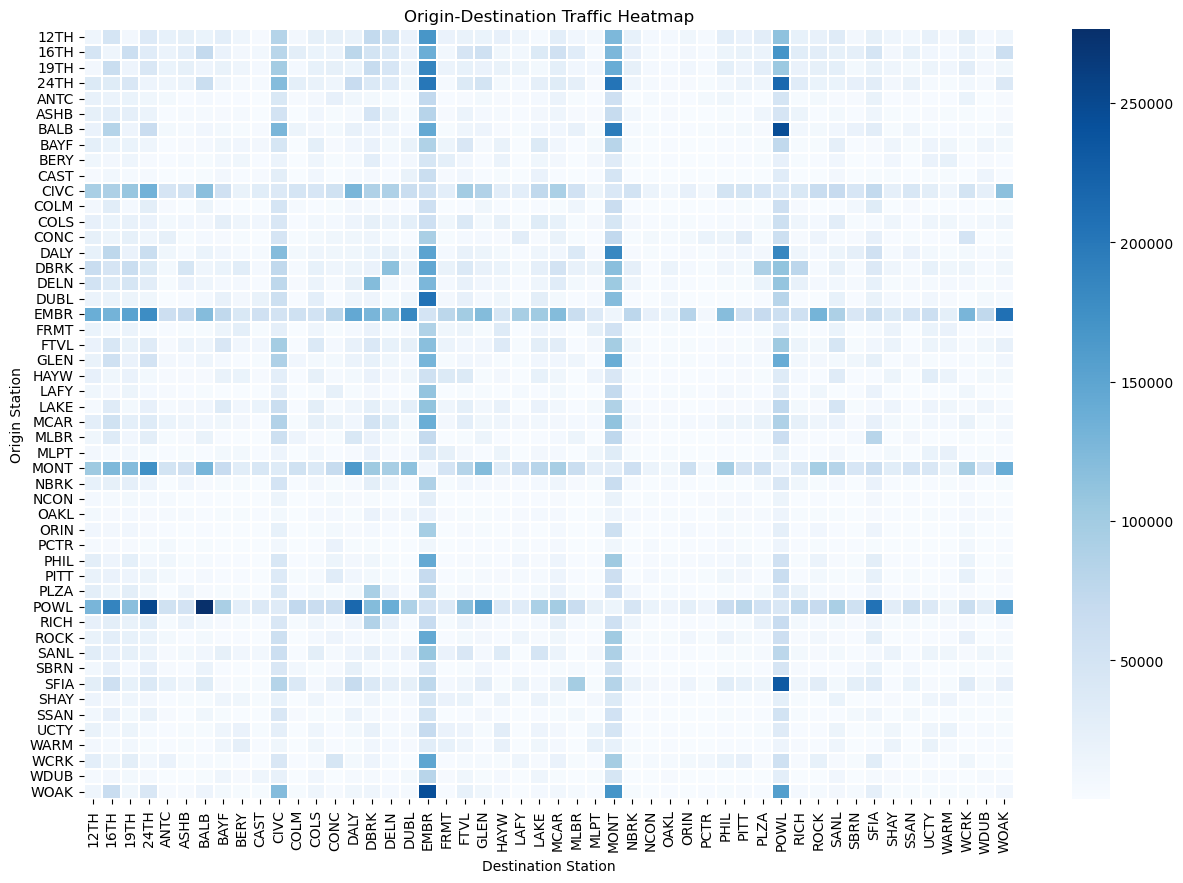

In [36]:
import seaborn as sns

# Create a pivot table of origin-destination flows
od_matrix = data.pivot_table(
    values='Number of Exits', 
    index='Origin Station', 
    columns='Destination Station', 
    aggfunc='sum', 
    fill_value=0
)

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(od_matrix, cmap='Blues', annot=False, linewidths=0.1)
plt.title('Origin-Destination Traffic Heatmap')
plt.show()


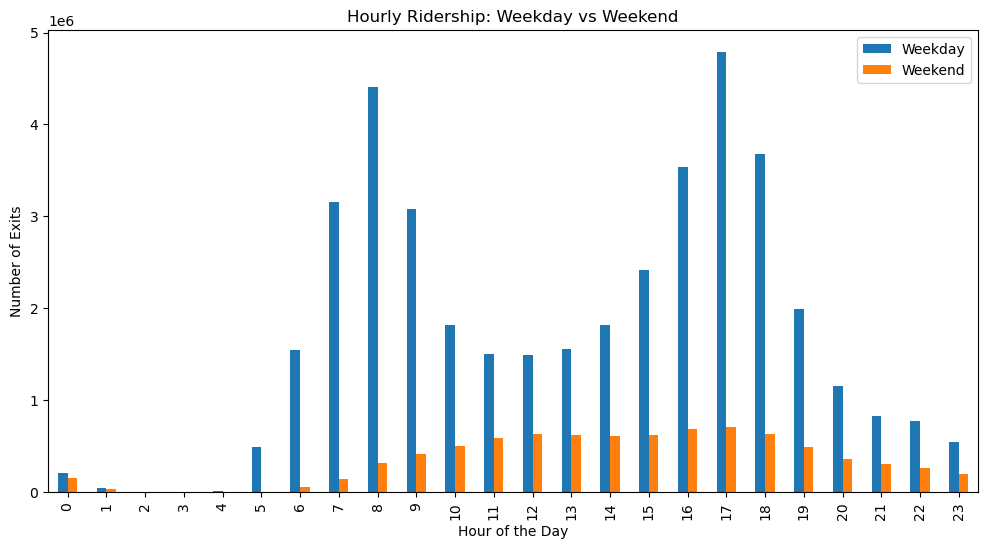

In [38]:
# Extract weekday and hour information
data['Day of Week'] = data['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
data['Is Weekend'] = data['Day of Week'].isin([5, 6])

# Aggregate ridership by hour and weekday
hourly_trends = data.groupby(['Hour (24-hour clock)', 'Is Weekend'])['Number of Exits'].sum().unstack()

# Plot peak vs off-peak ridership
hourly_trends.plot(kind='bar', figsize=(12, 6))
plt.title('Hourly Ridership: Weekday vs Weekend')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Exits')
plt.legend(['Weekday', 'Weekend'])
plt.show()


# Generating Weather Data

In [106]:
import requests
import pandas as pd

# Define county locations (latitude and longitude)
county_coords = {
    'San Francisco' : {'latitude': 37.7749, 'longitude': -122.4194},
    'San Mateo': {'latitude': 37.5630, 'longitude': -122.3255},
    'Alameda': {'latitude': 37.7652, 'longitude': -122.2416},
    'Contra Costa': {'latitude': 37.9358, 'longitude': -122.0652},
    'Santa Clara': {'latitude': 37.3337, 'longitude': -121.8907}
}

# Function to fetch weather data for a specific county
def fetch_weather_data(county_name, latitude, longitude):
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'start_date': '2018-01-01',
        'end_date': '2018-12-31',
        "hourly": ["temperature_2m", "precipitation", "weather_code", "wind_speed_10m", "wind_direction_10m", "relative_humidity_2m"],
        'timezone': 'America/Los_Angeles'
    }
    
    response = requests.get('https://archive-api.open-meteo.com/v1/archive', params=params)

    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data['hourly'])
        df['county'] = county_name  # Add county name column
        print(f"Data for {county_name} downloaded successfully!")
        return df
    else:
        print(f"Failed to retrieve data for {county_name}. Status code: {response.status_code}")
        return None

# Loop through the counties and fetch their weather data
weather_data_frames = []
for county, coords in county_coords.items():
    df = fetch_weather_data(county, coords['latitude'], coords['longitude'])
    if df is not None:
        weather_data_frames.append(df)

# Combine all weather data into a single DataFrame
weather_data = pd.concat(weather_data_frames, ignore_index=True)

weather_data.head()

Data for San Francisco downloaded successfully!
Data for San Mateo downloaded successfully!
Data for Alameda downloaded successfully!
Data for Contra Costa downloaded successfully!
Data for Santa Clara downloaded successfully!


,time,temperature_2m,precipitation,weather_code,wind_speed_10m,wind_direction_10m,relative_humidity_2m,county
0,2018-01-01T00:00,9.0,0.0,1,6.2,216,95,San Francisco
1,2018-01-01T01:00,9.9,0.0,2,4.4,171,93,San Francisco
2,2018-01-01T02:00,10.2,0.0,0,3.6,127,94,San Francisco
3,2018-01-01T03:00,8.9,0.0,1,5.0,90,98,San Francisco
4,2018-01-01T04:00,7.9,0.0,3,7.4,67,100,San Francisco


In [107]:
# Define the weather code mapping
weather_code_mapping = {
    0: 'Clear sky',
    1: 'Mainly clear',
    2: 'Partly cloudy',
    3: 'Overcast',
    45: 'Fog',
    48: 'Depositing rime fog',
    51: 'Light drizzle',
    53: 'Moderate drizzle',
    55: 'Dense drizzle',
    61: 'Slight rain',
    63: 'Moderate rain',
    65: 'Heavy rain',
    66: 'Freezing rain (light)',
    67: 'Freezing rain (heavy)',
    71: 'Slight snow',
    73: 'Moderate snow',
    75: 'Heavy snow',
    95: 'Thunderstorm',
    96: 'Thunderstorm with slight hail',
    99: 'Thunderstorm with heavy hail'
}

# Map the weather codes to their respective descriptions
weather_data['weather_category'] = weather_data['weather_code'].map(weather_code_mapping)

# Split the 'time' column into 'date' and 'hour'
weather_data['date'] = pd.to_datetime(weather_data['time']).dt.date  # Extract the date
weather_data['hour'] = pd.to_datetime(weather_data['time']).dt.hour  # Extract the hour

# Drop the original 'time' column if no longer needed
weather_data = weather_data.drop(columns=['time'])

# Reorder columns (optional)
weather_data = weather_data[['date', 'hour', 'temperature_2m', 'precipitation', 
                             'weather_code', 'wind_speed_10m', 'wind_direction_10m', 
                             'relative_humidity_2m', 'weather_category', 'county']]

# Save the combined data to a CSV file
weather_data.to_csv('weather_data_all_counties_2018.csv', index=False)
weather_data.head()

,date,hour,temperature_2m,precipitation,weather_code,wind_speed_10m,wind_direction_10m,relative_humidity_2m,weather_category,county
0,2018-01-01,0,9.0,0.0,1,6.2,216,95,Mainly clear,San Francisco
1,2018-01-01,1,9.9,0.0,2,4.4,171,93,Partly cloudy,San Francisco
2,2018-01-01,2,10.2,0.0,0,3.6,127,94,Clear sky,San Francisco
3,2018-01-01,3,8.9,0.0,1,5.0,90,98,Mainly clear,San Francisco
4,2018-01-01,4,7.9,0.0,3,7.4,67,100,Overcast,San Francisco


In [108]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  43800 non-null  object 
 1   hour                  43800 non-null  int32  
 2   temperature_2m        43800 non-null  float64
 3   precipitation         43800 non-null  float64
 4   weather_code          43800 non-null  int64  
 5   wind_speed_10m        43800 non-null  float64
 6   wind_direction_10m    43800 non-null  int64  
 7   relative_humidity_2m  43800 non-null  int64  
 8   weather_category      43800 non-null  object 
 9   county                43800 non-null  object 
dtypes: float64(3), int32(1), int64(3), object(3)
memory usage: 3.2+ MB


In [109]:
weather_data.isnull().sum()

date                    0
hour                    0
temperature_2m          0
precipitation           0
weather_code            0
wind_speed_10m          0
wind_direction_10m      0
relative_humidity_2m    0
weather_category        0
county                  0
dtype: int64

# Adding Counties to station-names file

In [45]:
import pandas as pd

# Load the station names file
stations_df = pd.read_excel("station-names.xls")  # Ensure the correct path is used

# Define the corrected mapping of stations to counties
station_to_county = {
    'EM': 'San Francisco', 'MT': 'San Francisco', 'PL': 'San Francisco', 'CC': 'San Francisco',
    '16': 'San Francisco', '24': 'San Francisco', 'GP': 'San Francisco', 'BP': 'San Francisco',
    'DC': 'San Mateo', 'CM': 'San Mateo', 'SS': 'San Mateo', 'SB': 'San Mateo',
    'SO': 'San Mateo', 'MB': 'San Mateo',
    'RM': 'Alameda', 'EN': 'Alameda', 'EP': 'Alameda', 'NB': 'Alameda', 'BK': 'Alameda',
    'AS': 'Alameda', 'MA': 'Alameda', '19': 'Alameda', '12': 'Alameda', 'LM': 'Alameda',
    'FV': 'Alameda', 'CL': 'Alameda', 'SL': 'Alameda', 'BF': 'Alameda', 'HY': 'Alameda',
    'SH': 'Alameda', 'UC': 'Alameda', 'FM': 'Alameda', 'WS': 'Alameda', 'OW': 'Alameda',
    'OA': 'Alameda', 'CV': 'Alameda',
    'CN': 'Contra Costa', 'PH': 'Contra Costa', 'WC': 'Contra Costa', 'LF': 'Contra Costa',
    'OR': 'Contra Costa', 'RR': 'Contra Costa', 'NC': 'Contra Costa', 'WP': 'Contra Costa',
    'PC': 'Contra Costa', 'AN': 'Contra Costa', 'WD': 'Contra Costa', 'ED': 'Contra Costa',
    'ML': 'Santa Clara', 'BE': 'Santa Clara'
}

# Map the 'Two-Letter Station Code' to the corresponding county
stations_df['County'] = stations_df['Two-Letter Station Code'].map(station_to_county)

stations_df.drop(columns=["Unnamed: 0"], inplace=True)

# Display the first few rows to verify the mapping
print(stations_df.head())

# Save the updated DataFrame with county information
stations_df.to_excel('station_names_with_counties.xlsx', index=False)  # Save as Excel
stations_df.to_csv('station_names_with_counties.csv', index=False)  # Save as CSV

  Two-Letter Station Code          Station Name   County
0                      RM              Richmond  Alameda
1                      EN  El Cerrito Del Norte  Alameda
2                      EP      El Cerrito Plaza  Alameda
3                      NB        North Berkeley  Alameda
4                      BK              Berkeley  Alameda


# Combining ridership data from 2018 to 2023

In [191]:
import pandas as pd
import glob

# === Step 1: Load and Concatenate All Ridership Files ===
# Define the column names for ridership data
ridership_columns = ['Date', 'Hour (24-hour clock)', 'Origin Station', 'Destination Station', 'Number of Exits']

# Use glob to load all ridership CSV files
ridership_files = glob.glob('date-hour-soo-dest-*.csv')  # Assuming files are named like 'ridership_2018.csv', 'ridership_2019.csv', etc.
ridership_data = pd.concat([pd.read_csv(file, names=ridership_columns, header=None) for file in ridership_files])

# Convert 'Date' to datetime format and extract 'year' column
ridership_data['Date'] = pd.to_datetime(ridership_data['Date'])
ridership_data['Year'] = ridership_data['Date'].dt.year

# Map origin stations to counties (using your station_to_county dictionary)
station_to_county = {
    'EMBR': 'San Francisco', 'MONT': 'San Francisco', 'POWL': 'San Francisco', 'CIVC': 'San Francisco',
    '16TH': 'San Francisco', '24TH': 'San Francisco', 'GLEN': 'San Francisco', 'BALB': 'San Francisco',
    'DALY': 'San Mateo', 'COLM': 'San Mateo', 'SSAN': 'San Mateo', 'SBRN': 'San Mateo',
    'SFIA': 'San Mateo', 'MLBR': 'San Mateo',
    'RICH': 'Alameda', 'DELN': 'Alameda', 'PLZA': 'Alameda', 'NBRK': 'Alameda', 'DBRK': 'Alameda',
    'ASHB': 'Alameda', 'MCAR': 'Alameda', '19TH': 'Alameda', '12TH': 'Alameda', 'LAKE': 'Alameda',
    'FTVL': 'Alameda', 'COLS': 'Alameda', 'SANL': 'Alameda', 'BAYF': 'Alameda', 'HAYW': 'Alameda',
    'SHAY': 'Alameda', 'UCTY': 'Alameda', 'FRMT': 'Alameda', 'WARM': 'Alameda', 'WOAK': 'Alameda',
    'OAKL': 'Alameda', 'CAST': 'Alameda',
    'CONC': 'Contra Costa', 'PHIL': 'Contra Costa', 'WCRK': 'Contra Costa', 'LAFY': 'Contra Costa',
    'ORIN': 'Contra Costa', 'ROCK': 'Contra Costa', 'NCON': 'Contra Costa', 'PITT': 'Contra Costa',
    'PCTR': 'Contra Costa', 'ANTC': 'Contra Costa', 'WDUB': 'Contra Costa', 'DUBL': 'Contra Costa',
    'MLPT': 'Santa Clara', 'BERY': 'Santa Clara'
}
ridership_data['county'] = ridership_data['Origin Station'].map(station_to_county)

In [195]:
ridership_data.head()

,Date,Hour (24-hour clock),Origin Station,Destination Station,Number of Exits,Year,county
0,2019-01-01,0,12TH,12TH,3,2019,Alameda
1,2019-01-01,0,12TH,16TH,4,2019,Alameda
2,2019-01-01,0,12TH,ANTC,1,2019,Alameda
3,2019-01-01,0,12TH,BAYF,1,2019,Alameda
4,2019-01-01,0,12TH,CIVC,2,2019,Alameda


In [197]:
ridership_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49687580 entries, 0 to 6598063
Data columns (total 7 columns):
 #   Column                Dtype         
---  ------                -----         
 0   Date                  datetime64[ns]
 1   Hour (24-hour clock)  int64         
 2   Origin Station        object        
 3   Destination Station   object        
 4   Number of Exits       int64         
 5   Year                  int32         
 6   county                object        
dtypes: datetime64[ns](1), int32(1), int64(2), object(3)
memory usage: 2.8+ GB


In [201]:
ridership_data.isnull().sum()

Date                    0
Hour (24-hour clock)    0
Origin Station          0
Destination Station     0
Number of Exits         0
Year                    0
county                  0
dtype: int64

In [203]:
ridership_data.to_csv('ridership_data_2018_to_2023.csv', index=False)

# Combining weather data from 2018 to 2023

In [208]:
weather_files = glob.glob('weather_data_all_counties_*.csv')  # Replace with actual filenames if needed
weather_data = pd.concat([pd.read_csv(file) for file in weather_files], ignore_index=True)

# Convert 'date' column to datetime format
weather_data['date'] = pd.to_datetime(weather_data['date'])

weather_data.head()

,date,hour,temperature_2m,precipitation,weather_code,wind_speed_10m,wind_direction_10m,relative_humidity_2m,weather_category,county
0,2021-01-01,0,10.6,0.0,0,2.6,304,79,Clear sky,San Francisco
1,2021-01-01,1,10.2,0.0,0,3.3,311,82,Clear sky,San Francisco
2,2021-01-01,2,9.7,0.0,0,5.1,82,85,Clear sky,San Francisco
3,2021-01-01,3,7.3,0.0,0,10.4,104,91,Clear sky,San Francisco
4,2021-01-01,4,7.0,0.0,0,7.9,106,91,Clear sky,San Francisco


In [212]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262920 entries, 0 to 262919
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date                  262920 non-null  datetime64[ns]
 1   hour                  262920 non-null  int64         
 2   temperature_2m        262920 non-null  float64       
 3   precipitation         262920 non-null  float64       
 4   weather_code          262920 non-null  int64         
 5   wind_speed_10m        262920 non-null  float64       
 6   wind_direction_10m    262920 non-null  int64         
 7   relative_humidity_2m  262920 non-null  int64         
 8   weather_category      262920 non-null  object        
 9   county                262920 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(2)
memory usage: 20.1+ MB


In [214]:
weather_data.isnull().sum()

date                    0
hour                    0
temperature_2m          0
precipitation           0
weather_code            0
wind_speed_10m          0
wind_direction_10m      0
relative_humidity_2m    0
weather_category        0
county                  0
dtype: int64

In [216]:
weather_data.to_csv('weather_data_2018_to_2023.csv', index=False)

In [218]:
# === Step 3: Merge BART Data with Weather Data ===
# Rename columns in bart_data to align with weather_data for merging
ridership_data = ridership_data.rename(columns={'Date': 'date', 'Hour (24-hour clock)': 'hour'})

# Merge the two datasets on 'date', 'hour', and 'county'
merged_data = pd.merge(ridership_data, weather_data, on=['date', 'hour', 'county'], how='left')
merged_data.head()

,date,hour,Origin Station,Destination Station,Number of Exits,Year,county,temperature_2m,precipitation,weather_code,wind_speed_10m,wind_direction_10m,relative_humidity_2m,weather_category
0,2019-01-01,0,12TH,12TH,3,2019,Alameda,8.2,0.0,0,32.0,17,48,Clear sky
1,2019-01-01,0,12TH,16TH,4,2019,Alameda,8.2,0.0,0,32.0,17,48,Clear sky
2,2019-01-01,0,12TH,ANTC,1,2019,Alameda,8.2,0.0,0,32.0,17,48,Clear sky
3,2019-01-01,0,12TH,BAYF,1,2019,Alameda,8.2,0.0,0,32.0,17,48,Clear sky
4,2019-01-01,0,12TH,CIVC,2,2019,Alameda,8.2,0.0,0,32.0,17,48,Clear sky


In [220]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49687580 entries, 0 to 49687579
Data columns (total 14 columns):
 #   Column                Dtype         
---  ------                -----         
 0   date                  datetime64[ns]
 1   hour                  int64         
 2   Origin Station        object        
 3   Destination Station   object        
 4   Number of Exits       int64         
 5   Year                  int32         
 6   county                object        
 7   temperature_2m        float64       
 8   precipitation         float64       
 9   weather_code          int64         
 10  wind_speed_10m        float64       
 11  wind_direction_10m    int64         
 12  relative_humidity_2m  int64         
 13  weather_category      object        
dtypes: datetime64[ns](1), float64(3), int32(1), int64(5), object(4)
memory usage: 5.0+ GB


In [222]:
merged_data.isnull().sum()

date                    0
hour                    0
Origin Station          0
Destination Station     0
Number of Exits         0
Year                    0
county                  0
temperature_2m          0
precipitation           0
weather_code            0
wind_speed_10m          0
wind_direction_10m      0
relative_humidity_2m    0
weather_category        0
dtype: int64

In [226]:
# === Step 4: Add Holiday Information ===
# Create a DataFrame with holiday dates and names
holidays = {
    # 2018
    '2018-01-01': 'New Year\'s Day',
    '2018-01-15': 'Martin Luther King Jr. Day',
    '2018-02-19': 'Presidents\' Day',
    '2018-03-31': 'César Chávez Day',
    '2018-05-28': 'Memorial Day',
    '2018-07-04': 'Independence Day',
    '2018-09-03': 'Labor Day',
    '2018-11-11': 'Veterans Day',
    '2018-11-22': 'Thanksgiving Day',
    '2018-12-25': 'Christmas Day',

    # 2019
    '2019-01-01': 'New Year\'s Day',
    '2019-01-21': 'Martin Luther King Jr. Day',
    '2019-02-18': 'Presidents\' Day',
    '2019-03-31': 'César Chávez Day',
    '2019-05-27': 'Memorial Day',
    '2019-07-04': 'Independence Day',
    '2019-09-02': 'Labor Day',
    '2019-11-11': 'Veterans Day',
    '2019-11-28': 'Thanksgiving Day',
    '2019-12-25': 'Christmas Day',

    # 2020
    '2020-01-01': 'New Year\'s Day',
    '2020-01-20': 'Martin Luther King Jr. Day',
    '2020-02-17': 'Presidents\' Day',
    '2020-03-31': 'César Chávez Day',
    '2020-05-25': 'Memorial Day',
    '2020-07-04': 'Independence Day',
    '2020-09-07': 'Labor Day',
    '2020-11-11': 'Veterans Day',
    '2020-11-26': 'Thanksgiving Day',
    '2020-12-25': 'Christmas Day',

    # 2021
    '2021-01-01': 'New Year\'s Day',
    '2021-01-18': 'Martin Luther King Jr. Day',
    '2021-02-15': 'Presidents\' Day',
    '2021-03-31': 'César Chávez Day',
    '2021-05-31': 'Memorial Day',
    '2021-07-04': 'Independence Day',
    '2021-09-06': 'Labor Day',
    '2021-11-11': 'Veterans Day',
    '2021-11-25': 'Thanksgiving Day',
    '2021-12-25': 'Christmas Day',

    # 2022
    '2022-01-01': 'New Year\'s Day',
    '2022-01-17': 'Martin Luther King Jr. Day',
    '2022-02-21': 'Presidents\' Day',
    '2022-03-31': 'César Chávez Day',
    '2022-05-30': 'Memorial Day',
    '2022-07-04': 'Independence Day',
    '2022-09-05': 'Labor Day',
    '2022-11-11': 'Veterans Day',
    '2022-11-24': 'Thanksgiving Day',
    '2022-12-25': 'Christmas Day',

    # 2023
    '2023-01-01': 'New Year\'s Day',
    '2023-01-16': 'Martin Luther King Jr. Day',
    '2023-02-20': 'Presidents\' Day',
    '2023-03-31': 'César Chávez Day',
    '2023-05-29': 'Memorial Day',
    '2023-07-04': 'Independence Day',
    '2023-09-04': 'Labor Day',
    '2023-11-10': 'Veterans Day (observed)',
    '2023-11-23': 'Thanksgiving Day',
    '2023-12-25': 'Christmas Day',
}

holidays_df = pd.DataFrame(list(holidays.items()), columns=['date', 'holiday_name'])
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

# Merge holidays with the merged BART-weather data
merged_data = pd.merge(merged_data, holidays_df, on='date', how='left')

# Add a new column 'is_holiday' (1 if holiday, 0 otherwise)
merged_data['is_holiday'] = merged_data['holiday_name'].apply(lambda x: 1 if pd.notna(x) else 0)
merged_data.head()

,date,hour,Origin Station,Destination Station,Number of Exits,Year,county,temperature_2m,precipitation,weather_code,wind_speed_10m,wind_direction_10m,relative_humidity_2m,weather_category,holiday_name,is_holiday
0,2019-01-01,0,12TH,12TH,3,2019,Alameda,8.2,0.0,0,32.0,17,48,Clear sky,New Year's Day,1
1,2019-01-01,0,12TH,16TH,4,2019,Alameda,8.2,0.0,0,32.0,17,48,Clear sky,New Year's Day,1
2,2019-01-01,0,12TH,ANTC,1,2019,Alameda,8.2,0.0,0,32.0,17,48,Clear sky,New Year's Day,1
3,2019-01-01,0,12TH,BAYF,1,2019,Alameda,8.2,0.0,0,32.0,17,48,Clear sky,New Year's Day,1
4,2019-01-01,0,12TH,CIVC,2,2019,Alameda,8.2,0.0,0,32.0,17,48,Clear sky,New Year's Day,1


In [228]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49687580 entries, 0 to 49687579
Data columns (total 16 columns):
 #   Column                Dtype         
---  ------                -----         
 0   date                  datetime64[ns]
 1   hour                  int64         
 2   Origin Station        object        
 3   Destination Station   object        
 4   Number of Exits       int64         
 5   Year                  int32         
 6   county                object        
 7   temperature_2m        float64       
 8   precipitation         float64       
 9   weather_code          int64         
 10  wind_speed_10m        float64       
 11  wind_direction_10m    int64         
 12  relative_humidity_2m  int64         
 13  weather_category      object        
 14  holiday_name          object        
 15  is_holiday            int64         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(6), object(5)
memory usage: 5.7+ GB


In [230]:
merged_data.isnull().sum()

date                           0
hour                           0
Origin Station                 0
Destination Station            0
Number of Exits                0
Year                           0
county                         0
temperature_2m                 0
precipitation                  0
weather_code                   0
wind_speed_10m                 0
wind_direction_10m             0
relative_humidity_2m           0
weather_category               0
holiday_name            48614665
is_holiday                     0
dtype: int64

# Final Dataset

In [237]:
merged_data.to_csv('ridership_and_weather_data_combined_2018_to_2023.csv', index=False)